# Projet FRI
Sylvestre Prabakaran

Benoît Laurès

Benoît Matet

## Librairies et outils de traitement de texte

Modifier les paths suivants si nécessaire. Les données sont supposées être dans un dossier `data` puis dans leurs dossiers respectifs (`data/CACM` et `data/pa1-data`).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

# Change path if necessary
path_to_cacm_file = 'data/CACM/cacm.all'
path_to_cs276_dir = 'data/pa1-data'
path_to_qrels = 'data/CACM/qrels.text'
path_to_query = 'data/CACM/query.text'
path_to_common_words = 'data/CACM/common_words'

In [2]:
import nltk

# Download useful tools
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Benoît\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Benoît\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Class Index
Classe mère pour les index adaptés aux bases de données.
Gère la lemmatization et la tokenization.

In [2]:
from index import *

## Traitement linguistique
Les résultats présentés pour chaque jeu de données sont reproductibles en exécutants les cellules associées.


### CACM
#### Q1
Nous trouvons 118 406 tokens dans la collection
#### Q2
Et un vocabulaire de 5 462 tokens différents
#### Q3
En ne lisant que la moitié des documents, on trouve un vocabulaire de 3 211 tokens différents, avec 32 463 tokens au total. On en tire les paramètres de Heap :

    k : 45.14218927762959
    b : 0.41052940261544163
#### Q4
En appliquant les paramètres de Heap, on peut prévoir un vocabulaire de taille 13 114 si la collection contenait 1M de tokens.
#### Q5 
Voir les résultats de la cellule

At half the docs : 
Vocabulary size : 3212
Nb tokens : 32463
Total
Vocabulary size : 5463
Nb tokens : 118406
Heaps parameters :
k : 45.20278539516267
b : 0.4104302428095791
checking the heaps parameters (the 2 following numbers should be equal):
5463.0
5463
If the data had 1M tokens, it would have roughly 13114 distinct words
('program', 2111)
('monica', 1)


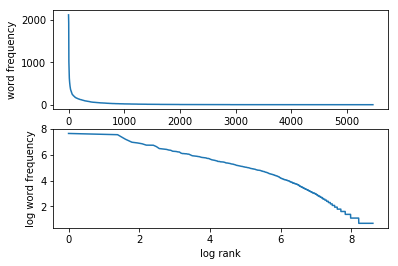

In [7]:
from q1_to_5_CACM import analysis
analysis(path_to_cacm_file)

### CS276
Les résultats présentés ici sont reproductibles en exécutants les cellules suivantes.

#### Q1
Nous trouvons 17 012 440 tokens dans la collection
#### Q2
Et un vocabulaire de 206 430 tokens différents
#### Q3
En ne lisant que la moitié des documents, on trouve un vocabulaire de 3 211 tokens différents, avec 32 463 tokens au total. On en tire les paramètres de Heap :

    k : 0.05036578468663431
    b : 0.9145139883303451
    
#### Q4
En appliquant les paramètres de Heap, on peut prévoir un vocabulaire de taille 15 460 si la collection contenait 1M de tokens.
#### Q5 
Voir les résultats de la cellule


Checking the saved results without reading again the dataset
Question 1 : 17012440 terms in the vocabulary
Question 2 : 206430 distinct tokens
Question 3 : Heaps Law : k = 0.05036578468663431 and b = 0.9145139883303451
Question 4 : For 1 million tokens, the vocabulary size would be 15460
Question 5


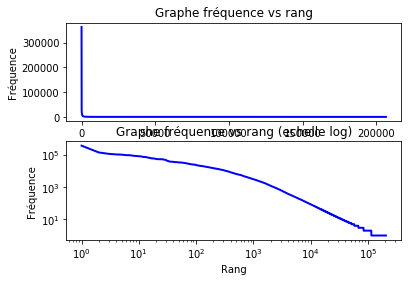

In [3]:
# Set redo_tokenization to True if you want to do again the tokenization and the dictionnary, 
# Otherwise, the saved dictionnary will be loaded
from q1_to_5_CS276 import *

analysis(path_to_cs276_dir, redo_tokenization=False)

## Index booléen
La classe BooleanIndex hérite de Index et permet de créer un index inverser sur la base de données CACM ou CS276 selon la méthode appelée. Les requêtes booléennes sont traitées comme un arbre d'opérations en donnant la priorité à NOT, puis OR, puis AND. On peut aussi entrer des requêtes parenthésées. Les fonctions utiles à la gestion de l'arbre sont dans tree_operator.py et permettent de transformer une requête sous forme de chaîne de caractère parenthésée à un arbre d'opérateurs où chaque nœud est une opération booléenne et chaque feuille est une token_id. L'arbre est ensuite parcouru par l'index et chaque opération est calculée.

Pour profiter au mieux de la structure de sparse matrix utilisée pour l'index inversée, l'opérations NOT n'est pas calculée telle quelle. Le résultat renvoyé par le parcours d'arbre renvoie une liste sparse avec un booléen par document, et un booléen indiquant si les documents renvoyés sont les documents pertinents ou au contraire les documents inintéressants. Cela permet de garder une quantité restreinte de documents en mémoire même lorsqu'on demande une requête du type "NOT paper"

In [3]:
from tree_operator import *
from boolean_index import BooleanIndex

### Pertinence des requêtes
Les fonctions de cette cellule implémentent toutes les mesures de pertinence des résultats et permettent de faire des rapport facilement pour l'évaluation des résultats de l'index sur les requêtes qu'on lui soumet

In [4]:
from metrics import *
import re

## Index booléen sur CACM
L'index est créé en une vingtaine de secondes et permet de traiter les requêtes en un temps de l'ordre du centième de seconde. Cependant, la pertinence des résultats est très basse. Notamment, le champ "auteur" n'étant pas utilisé pour le référencement, il est impossible de lancer des recherches sur un nom d'auteur.

In [12]:
index = BooleanIndex()
start = time()
print("Building index for CACM...")
index.build_cacm(path_to_cacm_file)
print("Index built in {:.1f}s".format(time()-start))

Building index for CACM...
Index built in 20.5s


['tss', 'or', 'time', 'and', 'share', 'and', 'system']
or
	tss
	and
		time
		and
			share
			system
Query treated in 0.1s
Docs found for query : TSS or (time and sharing and system)
[ 322  585  971  972 1071 1170 1341 1349 1391 1410 1487 1506 1519 1523
 1526 1544 1571 1572 1605 1657 1677 1740 1748 1749 1752 1792 1805 1811
 1827 1844 1877 1892 1901 1908 1938 1951 1960 1978 2036 2054 2069 2092
 2128 2130 2151 2218 2219 2228 2320 2344 2357 2371 2375 2377 2378 2380
 2399 2424 2439 2499 2500 2501 2522 2535 2621 2626 2629 2667 2730 2838
 2867 2920 2938 2947 2948 2950 2951 2954 3025 3112 3174 3204]
Docs we should have found :
[1410 1572 1605 2020 2358]
precision :			0.04
recall :			0.60
e_measure :			0.96
f_measure :			0.07
r_measure :			0.00
interpolated_precisions :	[0.15789473684210525, 0.15789473684210525, 0.15789473684210525, 0.15789473684210525, 0.15789473684210525, 0.15789473684210525, 0.15789473684210525, 0, 0, 0, 0]
average_precision :		0.10


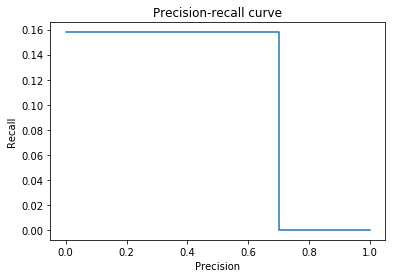

query 1 :	r : 0.60	p : 0.04	f1 : 0.07	(0.01s)
query 2 :	r : 0.00	p : NaN		f1 : 0.00	(0.01s)
query 3 :	r : 0.00	p : NaN		f1 : 0.00	(0.01s)
query 4 :	r : 1.00	p : 0.00	f1 : 0.01	(0.03s)
query 5 :	r : 0.25	p : 0.67	f1 : 0.36	(0.01s)
query 6 :	r : 0.33	p : 0.00	f1 : 0.00	(0.01s)
query 7 :	r : 0.00	p : 0.00	f1 : 0.00	(0.00s)
query 8 :	r : 0.00	p : NaN		f1 : 0.00	(0.01s)
query 9 :	r : 0.00	p : NaN		f1 : 0.00	(0.01s)
query 10 :	r : 0.23	p : 0.53	f1 : 0.32	(0.00s)
query 11 :	r : 0.58	p : 0.31	f1 : 0.40	(0.01s)
query 12 :	r : 0.20	p : 1.00	f1 : 0.33	(0.00s)
query 13 :	r : 0.00	p : NaN		f1 : 0.00	(0.00s)
query 14 :	r : 0.00	p : NaN		f1 : 0.00	(0.01s)
query 15 :	r : 0.00	p : NaN		f1 : 0.00	(0.00s)
query 16 :	r : 0.00	p : NaN		f1 : 0.00	(0.01s)
query 17 :	r : 0.06	p : 1.00	f1 : 0.12	(0.00s)
query 18 :	r : 0.00	p : NaN		f1 : 0.00	(0.01s)
query 19 :	r : 0.73	p : 0.32	f1 : 0.44	(0.00s)
query 20 :	r : 0.33	p : 1.00	f1 : 0.50	(0.01s)


In [10]:
queries = [
    "", # query id starts at 1 in the file
    #  What articles exist which deal with TSS (Time Sharing System), an
    # operating system for IBM computers?
    "TSS or (time and sharing and system)",

    "Prieve or (Udo and Pooch)",
    "intermediate and languages and used and construction and multi-targeted and compilers",
    "(mechanisms and communicating and disjoint and processes) and not abstract",
    "(design or implementation) and ((editing and interfaces) or window-managers or (command and interprets))",
    "(robotics or (motion and planning) or (geometric or combinatorial)) and not (dynamics and arm and motion)",
    "(distributed and algorithm) and (fault-tolerance or correctness)",
    "resource and addressing and network and operating and system",
    "security and local and (networks or (network and operating and system) or (distributed and system)",
    "parallel and language",
    "SETL or (very and high and level and language)",
    "portable and operating and system",
    "code and optimization and space and efficiency",
    "optimal and implementation and sort and algorithms and database and management and applications",
    "horizontal and microcode and optimization and loops",
    "file and handling and operating and systems and multiple and processes and message and passing",
    "optimization and intermediate and machine and code",
    "languages and compilers and parallel and processors and microcoded and machines",
    "parallel and algorithms",
    "graph and theoretic and algorithms and sparse and matrices"
    ]
truth_queries = read_truth(path_to_qrels)

full_query_report(index, queries[1], np.array(truth_queries[1]))


result_queries = []

for id_query in range(1, len(queries)):
    result = short_query_report(index, id_query, queries[id_query], truth_queries[id_query])
    result_queries += [result]
    
# mean_average_precision = compute_mean_average_precision(result_queries, truth_queries)
# print("mean average precision on {} queries : {}".format(id_query, mean_average_precision))


    
# mean_average_precision = compute_mean_average_precision(docs, truth_query)
# print("mean_average_precision : {:.2f}".format(mean_average_precision))

## Index vectoriel sur CACM


In [8]:
from vectorized_index import *

In [9]:
from time import time
begin = time()

vec_index = VectorizedIndex()
vec_index.build_cacm(path_to_cacm_file)
print('Construction time = {:.1f}'.format(time() - begin))

Construction time = 21.3


In [10]:
query_truth, query_texts = read_truth(path_to_qrels, query_path=path_to_query)

result_queries = []
for id_query in range(1, len(query_texts)):
    result = short_query_report(vec_index, id_query, query_texts[id_query], truth_queries[id_query])
    result_queries += [result]

query 1 :	r : 0.40	p : 0.20	f1 : 0.27	(0.37s)
query 2 :	r : 0.00	p : 0.00	f1 : 0.00	(0.24s)
query 3 :	r : 0.17	p : 0.10	f1 : 0.12	(0.24s)
query 4 :	r : 0.08	p : 0.10	f1 : 0.09	(0.25s)
query 5 :	r : 0.25	p : 0.20	f1 : 0.22	(0.25s)
query 6 :	r : 1.00	p : 0.30	f1 : 0.46	(0.24s)
query 7 :	r : 0.18	p : 0.50	f1 : 0.26	(0.25s)
query 8 :	r : 0.33	p : 0.10	f1 : 0.15	(0.24s)
query 9 :	r : 0.22	p : 0.20	f1 : 0.21	(0.24s)
query 10 :	r : 0.26	p : 0.90	f1 : 0.40	(0.25s)
query 11 :	r : 0.32	p : 0.60	f1 : 0.41	(0.25s)
query 12 :	r : 0.40	p : 0.20	f1 : 0.27	(0.24s)
query 13 :	r : 0.45	p : 0.50	f1 : 0.48	(0.24s)
query 14 :	r : 0.11	p : 0.50	f1 : 0.19	(0.24s)
query 15 :	r : 0.10	p : 0.10	f1 : 0.10	(0.25s)
query 16 :	r : 0.12	p : 0.20	f1 : 0.15	(0.24s)
query 17 :	r : 0.19	p : 0.30	f1 : 0.23	(0.25s)
query 18 :	r : 0.18	p : 0.20	f1 : 0.19	(0.25s)
query 19 :	r : 0.45	p : 0.50	f1 : 0.48	(0.28s)
query 20 :	r : 0.00	p : 0.00	f1 : 0.00	(0.27s)
query 21 :	r : 0.00	p : 0.00	f1 : 0.00	(0.27s)
query 22 :	r : 0.53	p 

## Index booléen sur CS276
L'index booléen pour CS276 marche exactement de la même manière que pour CACM si ce n'est qu'il prend plusieurs heures à être généré. Les

In [5]:
index = BooleanIndex()
start = time()
# index.build_cs276(directory_name=path_to_cs276_dir)
index.load_cs276_index()
print("Index built in {:.1f}s".format(time()-start))
start = time()

query = "SETL or (high and level and language)"
docs = index.treat_query(query, show_tree=True)
print("Query treated in {:.1f}s".format(time()-start))
print("Docs found for query : {}".format(query))
print(docs)

Loading index matrices
Loading dictionaries
Index built in 2.1s
['__UNK__', 'or', 'high', 'and', 'level', 'and', 'languag']
or
	__UNK__
	and
		high
		and
			level
			languag
Query treated in 0.1s
Docs found for query : SETL or (high and level and language)
[ 1467  1991  2935  3399  3979  4402  5604  5663  6368  6484  6869  9566
 10582 10723 10885 10913 10981 11201 11329 11412 12072 13191 13306 13582
 13872 14504 15479 15578 15927 16194 16319 16375 16600 16613 16773 16998
 17418 17520 17723 17896 18644 18718 19146 21099 21856 21889 22243 22275
 22632 23037 23118 23625 24306 25666 26072 26110 26961 27898 28001 28154
 28962 29441 29780 30539 30716 30791 30956 31496 31593 31659 31717 31804
 31876 31914 32007 32078 32662 32958 32965 33023 33114 33971 34100 34174
 34264 34515 34563 34650 35752 36004 36025 36079 37046 37302 37499 37620
 37861 37894 37979 38167 38228 38391 38867 38999 39106 39133 39241 39571
 39825 40369 40444 40936 41988 42509 43606 44493 45509 47174 47314 47673
 47874 47958 

## CS276 : Index vectoriel

In [ ]:
VectorizedIndex = BooleanIndex()
start = time()
index.build_cs276(path_to_cs276_dir)
print("Index built in {:.1f}s".format(time()-start))
